#### 1. Import Libraries and Load Data

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully")

All libraries imported successfully


In [24]:
# Load the dataset from raw data folder
data_path = Path('..') / 'data' / 'raw' / 'breast_cancer_data.csv'

try:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully")
    print(f"Original shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Dataset not found at {data_path}")
    print("Please run notebook 01_data_loading.ipynb first")

Dataset loaded successfully
Original shape: (569, 33)

First few rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.1

#### 2. Data Cleaning and Validation

In [25]:
print("STEP 1: REMOVE DUPLICATES")
print("="*60)
initial_rows = len(df)
df = df.drop_duplicates()
duplicates_removed = initial_rows - len(df)

print(f"Initial rows: {initial_rows}")
print(f"Duplicates removed: {duplicates_removed}")
print(f"Remaining rows: {len(df)}")

if duplicates_removed > 0:
    print(f"{duplicates_removed} duplicate rows removed")
else:
    print("No duplicates found")

STEP 1: REMOVE DUPLICATES
Initial rows: 569
Duplicates removed: 0
Remaining rows: 569
No duplicates found


In [26]:
print("\nSTEP 2: HANDLE MISSING VALUES")
print("="*60)

missing_counts = df.isnull().sum()
total_missing = missing_counts.sum()

if total_missing == 0:
    print("No missing values found in the dataset")
    print("Dataset quality check: PASSED")
else:
    print(f"Missing values detected:")
    for col in df.columns:
        if missing_counts[col] > 0:
            pct = (missing_counts[col] / len(df)) * 100
            print(f"  - {col}: {missing_counts[col]} ({pct:.2f}%)")
    
    # Find the target column first
    if 'diagnosis' in df.columns:
        key_col = 'diagnosis'
    else:
        object_cols = df.select_dtypes(include=['object']).columns.tolist()
        key_col = object_cols[0] if object_cols else df.columns[1]
    
    # Drop only rows where key column (target) has missing values
    rows_before = len(df)
    df = df.dropna(subset=[key_col])
    rows_removed = rows_before - len(df)
    
    print(f"Rows with missing target values removed: {rows_removed}")
    print(f"Remaining rows: {len(df)}")

print(f"\nFinal cleaned dataset shape: {df.shape}")


STEP 2: HANDLE MISSING VALUES
Missing values detected:
  - Unnamed: 32: 569 (100.00%)
Rows with missing target values removed: 0
Remaining rows: 569

Final cleaned dataset shape: (569, 33)


#### 3. Identify and Encode Target Variable

In [27]:
# Identify target column
# Look for 'diagnosis' column, otherwise use the first non-numeric or second column
if 'diagnosis' in df.columns:
    target_col = 'diagnosis'
else:
    # Find the first object dtype column or use second column
    object_cols = df.select_dtypes(include=['object']).columns.tolist()
    if object_cols:
        target_col = object_cols[0]
    else:
        target_col = df.columns[1]

print(f"Target column: {target_col}")
print(f"Data type: {df[target_col].dtype}")
print(f"\nDataframe shape: {df.shape}")
print(f"First few values of target: {df[target_col].head(10).tolist()}")
print(f"\nUnique values: {df[target_col].unique()}")
print(f"Value counts:")
print(df[target_col].value_counts())

# Check if target is categorical and needs encoding
if df[target_col].dtype == 'object':
    print(f"\nTarget variable is categorical - encoding required")
    # Create label encoder
    le = LabelEncoder()
    target_encoded = le.fit_transform(df[target_col])
    print(f"\nEncoding mapping:")
    for i, class_label in enumerate(le.classes_):
        print(f"  {class_label} → {i}")
else:
    print(f"\nTarget variable is already numeric")
    target_encoded = df[target_col].values
    le = None

Target column: diagnosis
Data type: object

Dataframe shape: (569, 33)
First few values of target: ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M']

Unique values: ['M' 'B']
Value counts:
diagnosis
B    357
M    212
Name: count, dtype: int64

Target variable is categorical - encoding required

Encoding mapping:
  B → 0
  M → 1


#### 4. Separate Features and Target

In [28]:
# Separate features and target
# Drop both 'id' (sample identifier) and target column
columns_to_drop = [target_col, 'id'] if 'id' in df.columns else [target_col]
X = df.drop(columns=columns_to_drop)
y = target_encoded if le is not None else df[target_col].values

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Columns dropped: {columns_to_drop}")
print(f"\nFeature columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Store feature names for later use
feature_names = X.columns.tolist()
print(f"\nFeatures and target separated successfully")

Features shape: (569, 31)
Target shape: (569,)
Columns dropped: ['diagnosis', 'id']

Feature columns (31):
   1. radius_mean
   2. texture_mean
   3. perimeter_mean
   4. area_mean
   5. smoothness_mean
   6. compactness_mean
   7. concavity_mean
   8. concave points_mean
   9. symmetry_mean
  10. fractal_dimension_mean
  11. radius_se
  12. texture_se
  13. perimeter_se
  14. area_se
  15. smoothness_se
  16. compactness_se
  17. concavity_se
  18. concave points_se
  19. symmetry_se
  20. fractal_dimension_se
  21. radius_worst
  22. texture_worst
  23. perimeter_worst
  24. area_worst
  25. smoothness_worst
  26. compactness_worst
  27. concavity_worst
  28. concave points_worst
  29. symmetry_worst
  30. fractal_dimension_worst
  31. Unnamed: 32

Features and target separated successfully


#### 5. Train-Test Split with Stratification

In [29]:
# Split data into training and testing sets
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y  # Stratified split for balanced distribution
)

print("TRAIN-TEST SPLIT (Stratified)")
print("="*60)
print(f"Test size: {test_size*100:.0f}%")
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nTraining set class distribution:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for cls, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"  Class {cls}: {count} ({pct:.1f}%)")

print(f"\nTest set class distribution:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for cls, count in test_dist.items():
    pct = count / len(y_test) * 100
    print(f"  Class {cls}: {count} ({pct:.1f}%)")

print(f"\nStratified train-test split completed")

TRAIN-TEST SPLIT (Stratified)
Test size: 20%

Training set: 455 samples (80.0%)
Test set: 114 samples (20.0%)

Training set class distribution:
  Class 0: 285 (62.6%)
  Class 1: 170 (37.4%)

Test set class distribution:
  Class 0: 72 (63.2%)
  Class 1: 42 (36.8%)

Stratified train-test split completed


#### 6. Feature Scaling (StandardScaler)

In [30]:
print("FEATURE SCALING (StandardScaler)")
print("="*60)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler on training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"StandardScaler fit and applied")

# Show statistics
print(f"\nScaling statistics (from training data):")
print(f"  Mean: {scaler.mean_[:5]}...")  # Show first 5 features
print(f"  Std Dev: {scaler.scale_[:5]}...")

# Verify scaling
print(f"\nAfter scaling - Training data statistics:")
print(f"  Mean: {X_train_scaled.mean(axis=0)[:5]}...")  # Should be close to 0
print(f"  Std Dev: {X_train_scaled.std(axis=0)[:5]}...")  # Should be close to 1

print(f"\nFeatures scaled successfully")
print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

FEATURE SCALING (StandardScaler)
StandardScaler fit and applied

Scaling statistics (from training data):
  Mean: [1.41660769e+01 1.94176923e+01 9.22158681e+01 6.59578242e+02
 9.59929451e-02]...
  Std Dev: [3.57514584e+00 4.28593536e+00 2.46899415e+01 3.60022403e+02
 1.42939574e-02]...

After scaling - Training data statistics:
  Mean: [-1.73731603e-16  3.90408097e-16  4.70441756e-16 -1.17122429e-16
  7.24207019e-16]...
  Std Dev: [1. 1. 1. 1. 1.]...

Features scaled successfully
Scaled training data shape: (455, 31)
Scaled test data shape: (114, 31)


C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


#### 7. Visualize Preprocessing Results

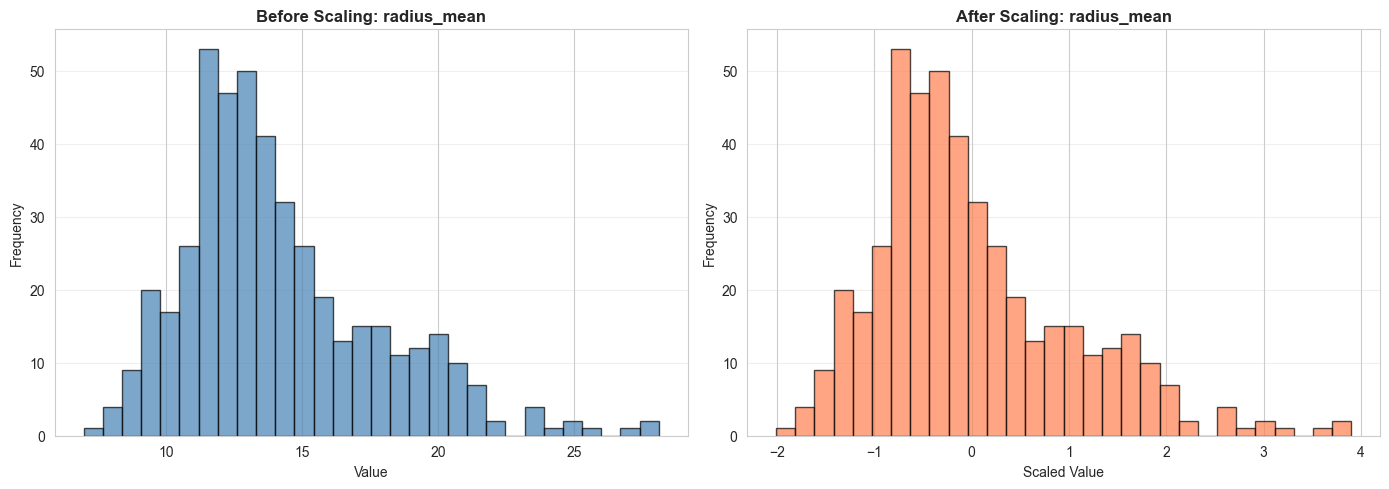

Scaling visualization complete


In [31]:
# Compare before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before scaling
feature_idx = 0  # First feature
axes[0].hist(X_train.iloc[:, feature_idx], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_title(f'Before Scaling: {feature_names[feature_idx]}', fontweight='bold')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

# After scaling
axes[1].hist(X_train_scaled[:, feature_idx], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title(f'After Scaling: {feature_names[feature_idx]}', fontweight='bold')
axes[1].set_xlabel('Scaled Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Scaling visualization complete")

#### 8. Save Preprocessed Data and Scaler

In [32]:
# Create output directories if they don't exist
processed_data_dir = Path('..') / 'data' / 'processed'
processed_data_dir.mkdir(parents=True, exist_ok=True)

models_dir = Path('..') / 'models'
models_dir.mkdir(parents=True, exist_ok=True)

# Save preprocessed data
np.save(processed_data_dir / 'X_train_scaled.npy', X_train_scaled)
np.save(processed_data_dir / 'X_test_scaled.npy', X_test_scaled)
np.save(processed_data_dir / 'y_train.npy', y_train)
np.save(processed_data_dir / 'y_test.npy', y_test)

# Save feature names
pd.DataFrame({'feature_names': feature_names}).to_csv(
    processed_data_dir / 'feature_names.csv', index=False
)

# Save the scaler for later use in predictions
joblib.dump(scaler, models_dir / 'scaler.pkl')

# Save label encoder if it exists
if le is not None:
    joblib.dump(le, models_dir / 'label_encoder.pkl')

print("PREPROCESSED DATA SAVED")
print("="*60)
print(f"X_train_scaled.npy: {X_train_scaled.shape}")
print(f"X_test_scaled.npy: {X_test_scaled.shape}")
print(f"y_train.npy: {y_train.shape}")
print(f"y_test.npy: {y_test.shape}")
print(f"feature_names.csv: {len(feature_names)} features")
print(f"scaler.pkl")
if le is not None:
    print(f"label_encoder.pkl")

print(f"\nLocation: {processed_data_dir.resolve()}")
print(f"Models: {models_dir.resolve()}")

print(f"\nPreprocessing pipeline complete!")

PREPROCESSED DATA SAVED
X_train_scaled.npy: (455, 31)
X_test_scaled.npy: (114, 31)
y_train.npy: (455,)
y_test.npy: (114,)
feature_names.csv: 31 features
scaler.pkl
label_encoder.pkl

Location: C:\Repos\breast-cancer-wisconsin\data\processed
Models: C:\Repos\breast-cancer-wisconsin\models

Preprocessing pipeline complete!


#### 9. Preprocessing Summary

In [33]:
print("\n" + "="*80)
print("PREPROCESSING PIPELINE SUMMARY")
print("="*80)

print(f"\n1. DATA CLEANING:")
print(f"   Removed {duplicates_removed} duplicate rows")
print(f"   Handled missing values: {total_missing} total")
print(f"   Final dataset shape: {df.shape}")

print(f"\n2. TARGET ENCODING:")
if le is not None:
    print(f"   Encoded categorical target to numeric")
    for i, class_label in enumerate(le.classes_):
        print(f"     - {class_label} → {i}")
else:
    print(f"   Target already numeric")

print(f"\n3. FEATURE ENGINEERING:")
print(f"   Total features: {len(feature_names)}")
print(f"   Feature names saved for future reference")

print(f"\n4. TRAIN-TEST SPLIT (Stratified):")
print(f"   Training set: {X_train_scaled.shape[0]} samples")
print(f"   Test set: {X_test_scaled.shape[0]} samples")
print(f"   Test size ratio: {test_size*100:.0f}%")
print(f"   Class balance preserved in both sets")

print(f"\n5. FEATURE SCALING (StandardScaler):")
print(f"   Mean: {scaler.mean_[:3]}... (≈ 0)")
print(f"   Std Dev: {scaler.scale_[:3]}... (≈ 1)")
print(f"   Applied to both training and test sets")

print(f"\n6. ARTIFACTS SAVED:")
print(f"   Preprocessed data (.npy files)")
print(f"   Scaler (for future predictions)")
print(f"   Label encoder (if applicable)")
print(f"   Feature names (for model interpretation)")

print(f"\n" + "="*80)
print("READY FOR MODEL TRAINING IN PHASE 4")
print("="*80)


PREPROCESSING PIPELINE SUMMARY

1. DATA CLEANING:
   Removed 0 duplicate rows
   Handled missing values: 569 total
   Final dataset shape: (569, 33)

2. TARGET ENCODING:
   Encoded categorical target to numeric
     - B → 0
     - M → 1

3. FEATURE ENGINEERING:
   Total features: 31
   Feature names saved for future reference

4. TRAIN-TEST SPLIT (Stratified):
   Training set: 455 samples
   Test set: 114 samples
   Test size ratio: 20%
   Class balance preserved in both sets

5. FEATURE SCALING (StandardScaler):
   Mean: [14.16607692 19.41769231 92.21586813]... (≈ 0)
   Std Dev: [ 3.57514584  4.28593536 24.68994149]... (≈ 1)
   Applied to both training and test sets

6. ARTIFACTS SAVED:
   Preprocessed data (.npy files)
   Scaler (for future predictions)
   Label encoder (if applicable)
   Feature names (for model interpretation)

READY FOR MODEL TRAINING IN PHASE 4
